In [17]:
import sys
#sys.path.insert(1,'/Users/kailaiwang/Documents/AEI_Research/TEOBResumS/eccentric/python')
sys.path.insert(1,'/work/kailai.wang/teobresums/Python')
import EOBRun_module
import sxs
import Functions as fun
from importlib import reload
fun=reload(fun)
import argparse
from configparser import ConfigParser
import corner
import os
import pandas as pd
import glob
import json
import numpy as np
from pycbc import psd
import h5py
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import dynesty
from dynesty import plotting as dyplot
from pycbc.waveform import td_approximants
import pycbc.psd
from pycbc.pool import choose_pool
import csv

In [18]:
try:
    parser = argparse.ArgumentParser(description="Simple argument parser")
    parser.add_argument("-c", action="store", dest="config_file")
    result = parser.parse_args()
    config_file=result.config_file
    parser = ConfigParser()
    parser.read(config_file)
    parser.sections()
except SystemExit: 
    print("SystemExit")
    parser = ConfigParser()
    parser.read('config_TSEOBNRE.ini')
    parser.sections()
    pass

sxs_root_folder="/work/francisco.jimenez/SXS/data/"


# Define the path to the nr files
model=parser.get('setup','model')
export_folder='/work/kailai.wang/Eccentricity_project/export_folder/mismatch_'+model
export_bool=eval(parser.get('setup','export'))
eccentric_index=int(parser.get('setup','index'))
eccentric_file_index=int(parser.get('setup','file_index'))

print(model)

if not os.path.exists(export_folder):
    os.mkdir(export_folder)
    print("Directory " , export_folder ,  " Created ")

eccentric_cases = pd.read_csv (r'SXS_eccentric_'+str(eccentric_file_index)+'.csv')
eccentric_cases_list = eccentric_cases['SXS_eccentric'][:]
eccentric_cases_list


# In[15]:


eccentric_case = sxs_root_folder+eccentric_cases_list[eccentric_index]
sxs_file = glob.glob(eccentric_case+'/*/rhOverM_Asymptotic_GeometricUnits_CoM.h5')
sxs_file.sort(reverse=True)
sxs_file = sxs_file[0]

json_metafiles = (glob.glob(eccentric_case+"/*/metadata.json", recursive = True))
json_metafiles.sort(reverse=True)
json_metafiles = json_metafiles[0]





SystemExit
TSEOBNRE


usage: ipykernel_launcher.py [-h] [-c CONFIG_FILE]
ipykernel_launcher.py: error: unrecognized arguments: -f /work/kailai.wang/.local/share/jupyter/runtime/kernel-f817d16c-b385-44cf-b331-426a299ff30a.json


In [19]:
#1361
mass=100
bvals1361=np.array([0.20846699,13.60933172])
bvals=bvals1361
model='TSEOBNRE'


SXS:BBH:1361
massratio:  1
mass1:  50.0000809814
mass2:  50.0000844185
spin1:  -6.39273815009e-06
spin2:  -6.60907033441e-06
eccentricity:  0.14872854377662179
Initial seperation:  16.6950250840487


/work/kailai.wang/venv/lib/python3.7/site-packages/ipykernel_launcher.py:96: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Skipped dynesty...
bvals: [ 0.20846699 13.60933172]
Mismatch: 0.009561547656233516


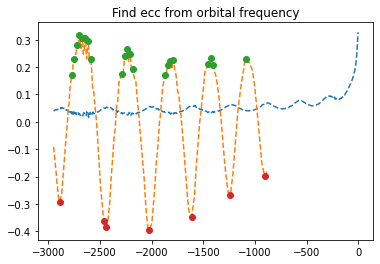

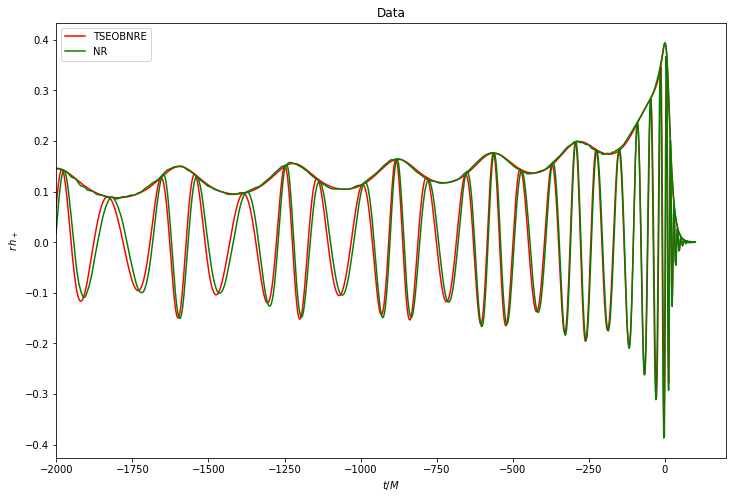

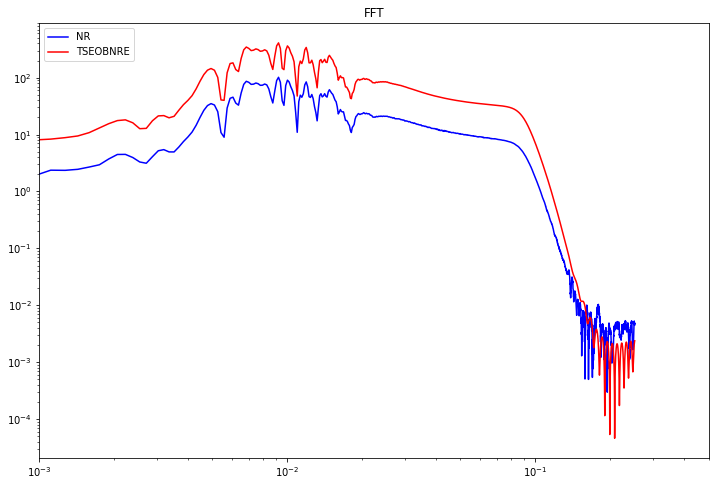

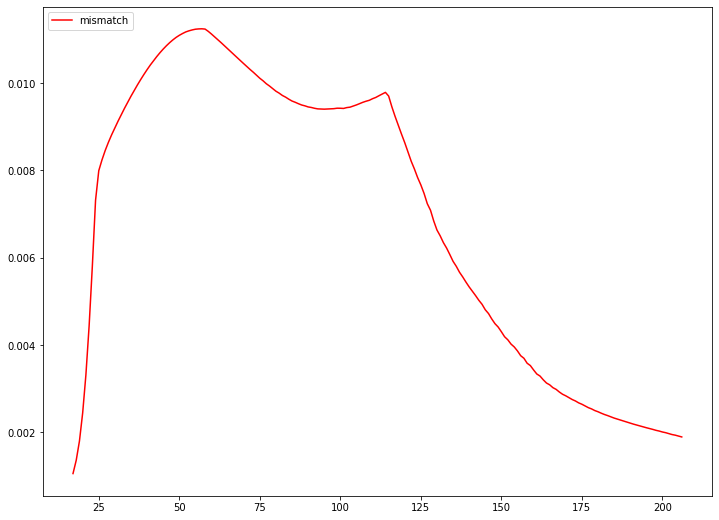

Max mismatch found: 0.011244744815893881


In [21]:
# Load SXS metadata
metadata = {}
for i in range(len(json_metafiles)):
    with open(json_metafiles) as file:
        metadata = json.load(file)

#mass = mass
BBH_name=metadata['alternative_names']
print(BBH_name)
mass1 = mass*metadata['reference_mass1']
mass2 = mass*metadata['reference_mass2']
massratio = max(mass1/mass2,1)
spin1 = metadata['reference_dimensionless_spin1'][-1]
spin2 = metadata['reference_dimensionless_spin2'][-1]
omega_0 =2*metadata["initial_orbital_frequency"]
T_0= 2*np.pi/omega_0
f_0 = omega_0/(2*np.pi)
# Load SXS data
gw = {}
gw = h5py.File(sxs_file, 'r') 

gw_sxs_bbh = gw["Extrapolated_N3.dir"]["Y_l2_m2.dat"] 
times = gw_sxs_bbh[:,0]
dt=fun.time_to_t_NR(1/1024.,mass)
sxs_wave=gw_sxs_bbh[:,1]-1j*gw_sxs_bbh[:,2]
tmrg = times[np.argmax(np.abs(sxs_wave))]
times = times - tmrg
times_nr=times
sxs_wave_nr = sxs_wave

sxs_wave_int=interp1d(times, sxs_wave, kind='cubic')
times= np.arange(times[0], times[-1], dt)
sxs_wave = sxs_wave_int(times)
sxs_wave = sxs_wave[np.argmax(times >= (times[0]+200)):np.argmax(times >= (-0))]
times = times[np.argmax(times >= (times[0]+200)):np.argmax(times >= (-0))]


sxsphas = np.angle(sxs_wave)
sxsphas = np.unwrap(sxsphas)
sxsfreq = np.gradient(sxsphas, times)
sxsfreq_int = interp1d(times,sxsfreq,kind='cubic')
plt.plot(times, sxsfreq, '--', label=r'$\Re{(Rh_{22}/(M\nu))}$')
plt.title(BBH_name)

#def estimate_ecc():
# Find the true anomaly, reference eccentricity and other parameters from metadata
di=metadata['initial_separation']
ecc_nr=metadata['reference_eccentricity']
#mean_anomaly=metadata['reference_mean_anomaly']
#true_anomaly=mean_anomaly+(2*ecc_nr-ecc_nr**3/4)*np.sin(mean_anomaly)+5/4*ecc_nr**2*np.sin(2*mean_anomaly)+13/12*ecc_nr**3*np.sin(3*mean_anomaly)
#perihelion=di*(1+ecc_nr*np.cos(true_anomaly))/(1-ecc_nr**2)
#(perihelion**2)*metadata['initial_adot']
#print(di)
#print(ecc_nr)
# Find eccentricity from orbital frequency
bool_fact=times<=times[0]+100+8*T_0
times_fit=times[bool_fact]
sxsfreq_fit=sxsfreq[bool_fact]
freqcfit=np.polyfit(times_fit, sxsfreq_fit, 2)
sxsfreq_fitc = np.poly1d(freqcfit)
sxsfreq_ecc_estimate=1-sxsfreq_fit/sxsfreq_fitc(times_fit)
sxsfreq_ecc_estimate=fun.moving_average(sxsfreq_ecc_estimate, 20)
times_fit = times_fit[:-19]
peaks_pos=find_peaks(sxsfreq_ecc_estimate, height=0)
peaks_neg=find_peaks(-sxsfreq_ecc_estimate, height=-0)
plt.plot(times_fit, sxsfreq_ecc_estimate, '--', label=r'$circular$')
plt.plot(times_fit[peaks_pos[0]], peaks_pos[1]['peak_heights'], 'o', label=r'$circular$')
plt.plot(times_fit[peaks_neg[0]],-peaks_neg[1]['peak_heights'], 'o', label=r'$circular$')
plt.title("Find ecc from orbital frequency")

# eccentricity estimate as in Eq. 2.8 odf 1909.11011
wp =omega_0*(1 + np.mean(peaks_pos[1]['peak_heights']))
wa =omega_0*(1 - np.mean(peaks_neg[1]['peak_heights']))
ecc_NR = (wp**0.5 - wa**0.5)/(wp**0.5 + wa**0.5)
print('massratio: ',massratio)
print('mass1: ',mass1)
print('mass2: ',mass2)
print('spin1: ',spin1)
print('spin2: ',spin2)
print('eccentricity: ', ecc_NR)
print('Initial seperation: ',di)

export_file=export_folder+'/model_'+model+'_massratio_'+str(np.around(massratio,2))+'_spin1_'+str(np.around(spin1,2))+'_spin2_'+str(np.around(spin2,2))+'_ecc_'+str(np.around(bvals[0],3))+'_eccNR_'+str(np.around(ecc_NR,3))+'.csv'
mismatch_plot=export_folder+'/mm_model_'+model+'_massratio_'+str(np.around(massratio,2))+'_spin1_'+str(np.around(spin1,2))+'_spin2_'+str(np.around(spin2,2))+'_ecc_'+str(np.around(bvals[0],3))+'_eccNR_'+str(np.around(ecc_NR,3))+'.png'
wave_td_plot=export_folder+'/td_model_'+model+'_massratio_'+str(np.around(massratio,2))+'_spin1_'+str(np.around(spin1,2))+'_spin2_'+str(np.around(spin2,2))+'_ecc_'+str(np.around(bvals[0],3))+'_eccNR_'+str(np.around(ecc_NR,3))+'.png'
wave_fd_plot=export_folder+'/fd_model_'+model+'_massratio_'+str(np.around(massratio,2))+'_spin1_'+str(np.around(spin1,2))+'_spin2_'+str(np.around(spin2,2))+'_ecc_'+str(np.around(bvals[0],3))+'_eccNR_'+str(np.around(ecc_NR,3))+'.png'

#def dynesty():
emin=0
distance = 100; inclination = 0; l=2; m=2; 
emax=0.41
ecc_clas=fun.Eccentricity_PE([mass1,mass2,spin1,spin2,distance],
                      sxsfreq_int,model=model,times=times,sxsfreq=sxsfreq,
                      emin=emin,emax=emax,fmin=5,fmax=10)
ecc_clas.log_likelihood([0.1,10])
if bvals==[]:
    print("Running dynesty...")
    #Define min and max eccentricity for the priors
    pool = choose_pool(8)
    pool.size=8
    nlive = 1000
    f2=dynesty.NestedSampler(ecc_clas.log_likelihood,ecc_clas.prior_transform,
                     2,nlive=nlive,sample='rwalk',pool=pool)
    f2.run_nested(print_progress=True,dlogz=0.1)
    pool.close()
    res = f2.results
    res.samples_u.shape
    res.summary()
    samps=f2.results.samples
    postsamps = fun.posterior_samples(f2)
    bvals = postsamps[-1]
    fg=corner.corner(postsamps,quantiles=[0.05,0.5,0.95],show_titles=True,max_n_ticks = 4,bins=50,truths=bvals,labels=['e','f'],truth_color='red')
    plt.show()
else:
    print("Skipped dynesty...")
    bvals=bvals
print("bvals: "+ str(bvals))

#def final_wave():
dict = {'SEOBNRE':ecc_clas.model_SEOBNRE,'TSEOBNRE':ecc_clas.model_TSEOBNRE}
times_seobe, h_seobe_nr= dict[model](bvals,strain=True)
times_seobe_phys = fun.time_to_t_Phys(times_seobe,mass)
h_seobe_phys = fun.amp_to_phys(h_seobe_nr,mass,distance,2,2,0)

#def plot_the_data():
if times_seobe[0]>=times[0]:
    times_seobe_v1 = times_seobe[:np.argmax(times_seobe >= (100))]
    h_seobe_nr = h_seobe_nr[:np.argmax(times_seobe >= (100))]
    sxs_wave = sxs_wave_int(times_seobe_v1)
    times = times_seobe_v1
else:
    times = np.arange(times[0], 100, dt)
    sxs_wave = sxs_wave_int(times)

    eob_int=interp1d(times_seobe, h_seobe_nr, kind='cubic')
    h_seobe_nr=eob_int(times)
# plot the nr data in phys. units
figband = plt.figure(figsize = (12, 8))
paper_prefactor=0.204124145232
plt.plot(times, 0.25*h_seobe_nr.real, label=model,color='r')
plt.plot(times, 0.25*np.sqrt(h_seobe_nr.real**2+h_seobe_nr.imag**2),color='r',label=None)

#   plt.plot(times, 0.19*h_seobe_nr*(np.exp(1j*3.14)).real, label=model,color='r')
#   plt.plot(times, 0.19*np.sqrt(h_seobe_nr.real**2+h_seobe_nr.imag**2),color='r',label=None)

plt.plot(times, sxs_wave.real, label='NR',color='g')
plt.plot(times, np.sqrt(sxs_wave.real**2+sxs_wave.imag**2),color='g',label=None)
plt.xlabel(r'$t/M$')
plt.ylabel(r'$r \, h_+$')
plt.xlim(-2000,200)
plt.title(r'inclination = '+str(inclination/np.pi))
plt.legend(loc='upper left')
plt.title("Data")
if export_bool:
    figband.savefig(wave_td_plot)
#fourier and another plot
h_px=np.array([times,sxs_wave]).T 
h_eob=np.array([times,h_seobe_nr]).T 
tlow_nr = h_eob[0,0]+ 150
thigh_nr = 150
sigmalo = 100

tlow_eob = h_eob[0,0]+ 150
thigh_eob = 150

px_fft=fun.FFT_ZeroPadded_Windowed( h_px, nleft=1000,nright=1000,x_low=tlow_nr, sigma_low=sigmalo,x_high=thigh_nr,sigma_high=sigmalo)
eob_fft=fun.FFT_ZeroPadded_Windowed(h_eob,nleft=1000,nright=1000,x_low=tlow_eob,sigma_low=sigmalo,x_high=thigh_eob,sigma_high=sigmalo)
flow = 8
delta_f = 1.0 /16
flen = int(2048 / delta_f) + 1
frange=np.arange(flow,flow+delta_f*flen,delta_f)
psd_noise = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
psd_int=interp1d(frange, psd_noise, kind='cubic')

figband = plt.figure(figsize = (12, 8))
plt.plot(px_fft[:,0], np.abs(px_fft[:,1]),'b',label='NR')
plt.plot(eob_fft[:,0], np.abs(eob_fft[:,1]),'r',label=model)
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlim(0.001,0.5)
plt.title("FFT")
if export_bool:
    figband.savefig(wave_fd_plot)
#def compute_mismatch():
print("Mismatch: "+ str(1-fun.EasyMatch(px_fft,eob_fft,psd_int,20,2000,nright=3000,f_units='Mf',mass=mass)))
#mismatch between different masses
mmatch=[None]*198
for m in range(10,200):
    fmin=max(fun.f_to_Phys(f_0,m),20)
    #print(fmin)
    mmatch[m-3]=1-fun.EasyMatch(px_fft,eob_fft,psd_int,fmin,1000,nright=3000,f_units='Mf',mass=m)
figband = plt.figure(figsize = (12, 9))
x=np.arange(10,208)
plt.plot(x, mmatch,'r',label=r'mismatch')
plt.legend(loc='upper left')
if export_bool:
    figband.savefig(mismatch_plot)
plt.show()
acc_max=-1000
for i in mmatch:
    if i!=None and i>=acc_max:
        acc_max=i
print("Max mismatch found: " + str(acc_max))

if export_bool:
    with open(export_file,'w') as file:
        writer =csv.writer(file)
        writer.writerow(['mass','mismatch'])
        writer.writerows(np.array([x,mmatch]).T)